# Face Recognition on a subset of the Labeled Faces in the Wild dataset

In [64]:
%pylab inline

import pylab as pl #Es matplotlib.pyplot y numpy
import numpy as np 

Populating the interactive namespace from numpy and matplotlib


## The LFW dataset

Let's start with downloading the data using a scikit-learn utility function.

In [65]:
from sklearn.datasets import fetch_lfw_people #fetch en inglés significar ir recoger y traer

lwf_people = fetch_lfw_people(min_faces_per_person= 70, resize = 0.4)

In [66]:
type(lwf_people)

sklearn.utils.Bunch

Let's introspect the images arrays to find the shapes (for plotting with matplotlib)

In [67]:
X = lwf_people.data
y = lwf_people.target

names = lwf_people.target_names

n_samples, n_features = X.shape
_, h, w = lwf_people.images.shape
n_classes = len(names)

In [68]:
h * w

1850

In [69]:
print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 1288
n_features: 1850
n_classes: 7


In [70]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


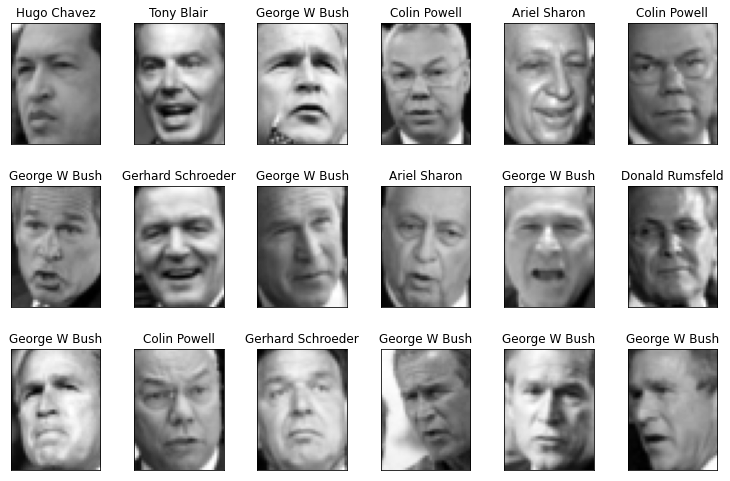

In [71]:
plot_gallery(X, names[y], h, w)

Let's have a look at the repartition among target classes:

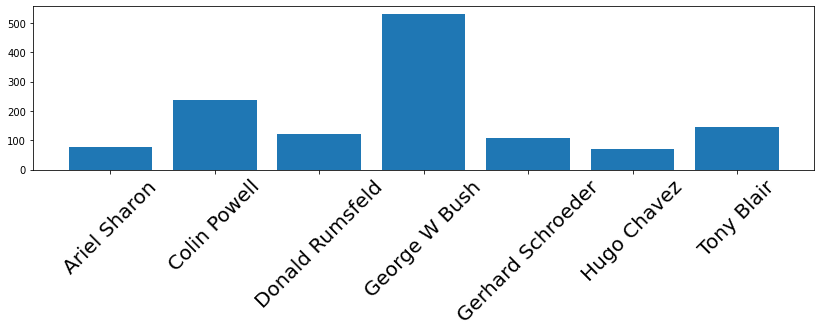

In [72]:
pl.figure(figsize=(14,3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique, names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation= 45, size=20)
_ = pl.bar(y_unique, counts)

## Splitting the dataset for model development and then evaluation

Let's split the data in a development set and final evaluation set.

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Unsupervised Feature Extraction with Randomized PCA

To train a model we will first reduce the dimensionality of the original picture to a 150 PCA space: unsupervised feature extraction.

In [74]:
from sklearn.decomposition import PCA

n_components = 150

print("Extracting the top %d eigenfaces from %d faces" %(n_components, X_train.shape[0]))

pca = PCA(n_components= n_components, whiten = True)

%time pca.fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 150 eigenfaces from 966 faces
Wall time: 320 ms


In [75]:
"""
de tus columnas originales
==> valor propio y vector propio(vector propio1, valor propio1)
==> valor propio y vector propio(vector propio2, valor propio2) 
==> valor propio y vector propio(vector propio3, valor propio3)
"""

'\nde tus columnas originales\n==> valor propio y vector propio(vector propio1, valor propio1)\n==> valor propio y vector propio(vector propio2, valor propio2) \n==> valor propio y vector propio(vector propio3, valor propio3)\n'

Let's plot the gallery of the most significant eigenfaces:

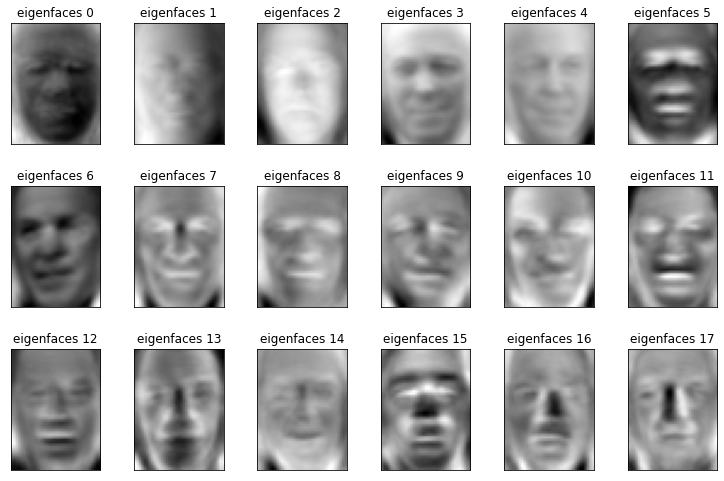

In [76]:
eigenfaces_titles = ["eigenfaces %d" % i for i in range(eigenfaces.shape[0])]

plot_gallery(eigenfaces, eigenfaces_titles, h, w)

Projecting the input data on the eigenfaces orthonormal basis:

In [77]:
X_train_pca = pca.transform(X_train)

## Training a Gaussian Kernel Support Vector Machine

Let's now train a Kernel Support Vector Machine on the projected data. We perform an automated parameter search to find good values for Gamma and C:

In [78]:
from sklearn.svm import SVC
svm = SVC(kernel= 'rbf', class_weight=None)
svm

SVC()

Unfortunately an SVM is very sensitive to the parameters C and gamma and it's very unlikely that the default parameters will yield a good predictive accurracy:

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

%time svm_cv_score = cross_val_score(estimator=svm, X= X_train_pca, y= y_train) #el kfolk del cv por defecto son 5, nos devuelve 5 'accuracies'
svm_cv_score

Wall time: 726 ms


array([0.70103093, 0.66839378, 0.70984456, 0.67875648, 0.69430052])

In [80]:
svm_cv_score.mean(), svm_cv_score.std() #media del CrossValidation y desviación

(0.6904652529245231, 0.015007634890989639)

## Data-driven hyper-parameters tuning using a Cross-Validated Grid Search

Fortunately we can automate the search for the best combination of parameters:

In [81]:
from sklearn.model_selection import GridSearchCV

para_grid = {
            "C":[5, 5e2,  5e3, 1],
            "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
            }

clf = GridSearchCV(svm, para_grid, scoring= 'balanced_accuracy', cv=5) #Se utiliza 'balanced_accuracy', es una métrica similar al accuracy pero cuando las clases están más desbalanceadas ==> resultado media de balanced_accuracy de todos los resultado CValidation
#neg_log_loss ==> perdidas_logaritmicas_negativas - sería la mejor métirica a utilizar en CLASIFICACIÓN ó el 'F1'

In [82]:
%time clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by randomized parameter search: ")
print(clf.best_params_)
print("Best parameters validation score: {:.3f}".format(clf.best_score_))

Wall time: 14.5 s
Best estimator found by randomized parameter search: 
{'C': 500.0, 'gamma': 0.001}
Best parameters validation score: 0.748


## Final evaluation of the best model on the held-out test set

Let's start with a qualitative inspection of the some of the predictions:

In [83]:
X_test_pca = pca.transform(X_test)
y_pred = clf.predict(X_test_pca)

In [84]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, names, i)
                     for i in range(y_pred.shape[0])]

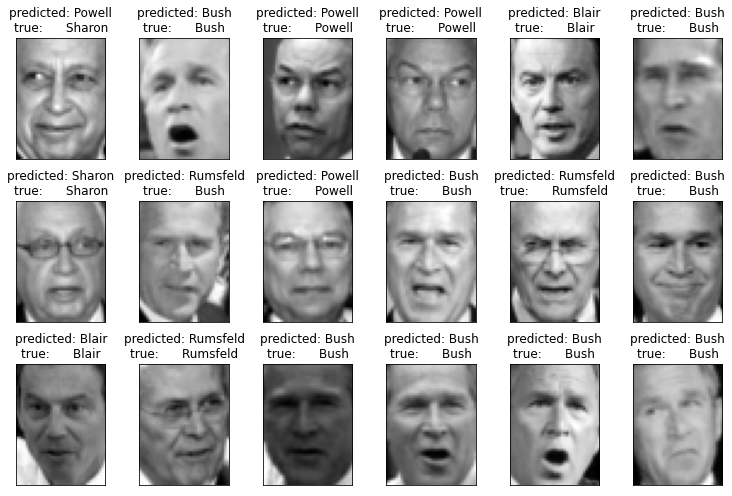

In [85]:
plot_gallery(X_test, prediction_titles, h, w)

In [86]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names= names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.80      0.69        15
     Colin Powell       0.82      0.84      0.83        58
  Donald Rumsfeld       0.79      0.81      0.80        27
    George W Bush       0.90      0.90      0.90       134
Gerhard Schroeder       0.69      0.72      0.71        25
      Hugo Chavez       0.81      0.68      0.74        19
       Tony Blair       0.89      0.77      0.83        44

         accuracy                           0.83       322
        macro avg       0.79      0.79      0.78       322
     weighted avg       0.84      0.83      0.83       322



In [ ]:
# Macro_avg ==> hace la media sobre todos datos sobre [precission, recall, ...]
# El macro se aplicaría sobre clasificación con balanceo entre las clases

# Weigthed_avg ==> es una métrica que tiene en cuenta el desbalanceo... ya que pondera los pesos según su resultados y el número de nuestras
# Esta métrica se tiene más en cuenta cuando hay balanceadas estén las clases

In [88]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels= range(n_classes))
print(cm)

[[ 12   1   0   1   0   0   1]
 [  2  49   0   5   1   0   1]
 [  1   1  22   2   1   0   0]
 [  4   5   2 120   1   1   1]
 [  0   1   2   2  18   1   1]
 [  1   2   0   1   2  13   0]
 [  0   1   2   3   3   1  34]]


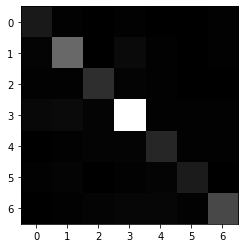

In [91]:
pl.gray()
_ = plt.imshow(cm, interpolation = 'nearest')